In [137]:
import pandas as pd
import nltk
import gzip
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

In [109]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def readSerialized(path):
    return pd.read_pickle(path)

df = getDF('reviews_Musical_Instruments_5.json.gz')

In [118]:
df = readSerialized('serialized_electronics')

In [119]:
df.head()

,summary,reviewerName,reviewTime,overall,asin,helpful,unixReviewTime,reviewerID,reviewText
0,Gotta have GPS!,amazdnu,"06 2, 2013",5.0,0528881469,"[0, 0]",1370131200,AO94DHGC771SJ,We got this GPS for my husband who is an (OTR)...
1,Very Disappointed,Amazon Customer,"11 25, 2010",1.0,0528881469,"[12, 15]",1290643200,AMO214LNFCEI4,"I'm a professional OTR truck driver, and I bou..."
2,1st impression,C. A. Freeman,"09 9, 2010",3.0,0528881469,"[43, 45]",1283990400,A3N7T0DY83Y4IG,"Well, what can I say. I've had this unit in m..."
3,"Great grafics, POOR GPS","Dave M. Shaw ""mack dave""","11 24, 2010",2.0,0528881469,"[9, 10]",1290556800,A1H8PY3QHMQQA0,"Not going to write a long review, even thought..."
4,"Major issues, only excuses for support",Wayne Smith,"09 29, 2011",1.0,0528881469,"[0, 0]",1317254400,A24EV6RXELQZ63,I've had mine for a year and here's what we go...


In [120]:
def getScore(x):
    if(len(x) == 2 and  x[1] > 2):
        return x[0] / x[1]
    return 0

In [123]:
df2 = df.copy()
df2['reviewLength'] = df2['reviewText'].str.len()
df2['score'] = df2.apply(lambda x : getScore(x['helpful']), axis=1)
df2 = df2[['asin','score','reviewLength']]

In [126]:
df2 = df2.sort_values(['score','reviewLength'],ascending=False)
display(df2)

,asin,score,reviewLength
713354,B0035LCZSG,1.0,32270
1520760,B00AFKBIYW,1.0,25611
1004241,B004QC3CMG,1.0,24955
1419090,B008R7EVE4,1.0,24723
742715,B003BEDTBY,1.0,22028
1442873,B0093H4VSS,1.0,21698
1655598,B00F6EOB8C,1.0,20976
1376975,B0089WM01S,1.0,19493
682376,B002XQ3C0E,1.0,18638
1488186,B009RXUAB0,1.0,18294


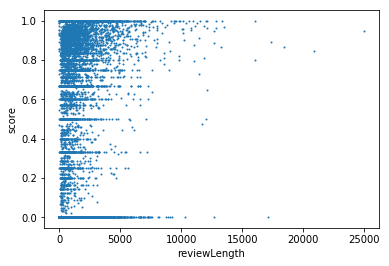

In [148]:
from pandas.tools.plotting import bootstrap_plot

dfplot = df2[['score','reviewLength']].sample(n=50000)

dfplot.plot.scatter(y = 'score',x ='reviewLength',style=['o', 'rx'], s=1)
plt.show()

In [115]:
df2 = df.groupby(["asin"])['reviewText'].agg(lambda x:''.join(set(x))).reset_index()
df2.head()

,asin,reviewText
0,0528881469,We got this GPS for my husband who is an (OTR)...
1,0594451647,This adapter easily connects my Nook HD 7&#34;...
2,0594481813,"This is a good beefy 2 amp charger, but it cov..."
3,0972683275,"I must admit, I'm very cautious of what I buy ..."
4,1400501466,The nook tablet is great.I have used it to che...


In [227]:
def filterTags(w1,w2):
    return (nltk.pos_tag(nltk.word_tokenize(w1))[0][1] == 'JJ' and nltk.pos_tag(nltk.word_tokenize(w2))[0][1] == 'NN') or \
     (nltk.pos_tag(nltk.word_tokenize(w1))[0][1] == 'RB' and nltk.pos_tag(nltk.word_tokenize(w2))[0][1] == 'VBN')

def getBest(text):
    ignored_words = nltk.corpus.stopwords.words('english')
    word_filter = lambda w: len(w) < 3 or w.lower() in ignored_words
    
    tokens = nltk.word_tokenize(text)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    
    finder = nltk.BigramCollocationFinder.from_words(tokens)
    finder.apply_word_filter(word_filter)    
    finder.apply_freq_filter(3)
    res = finder.ngram_fd.most_common(3)
        
    res = [x for x in res if filterTags(x[0][0],x[0][1])]

    if(len(res) > 0):
        return res
    else:
        return np.nan

In [228]:
from timeit import default_timer as timer

dfProduct = df.groupby(["asin"])['reviewText'].agg(lambda x:''.join(set(x))).reset_index()
dfProduct = dfProduct.sample(n=2000)

start = timer()
dfProduct["reviewText"] = dfProduct["reviewText"].apply(lambda x: getBest(x))
end = timer()
print(end - start)  

183.15147693827157


In [231]:
dfProduct = dfProduct.dropna(how = 'any')
dfProduct

,asin,reviewText
30421,B003MQO96U,"[((Wireless-N, Travel), 3)]"
25650,B002UBE15C,"[((well, made), 9)]"
13310,B000V4VIJW,"[((hard, drive), 5)]"
35595,B004G5ZSW0,"[((hard, drive), 11)]"
47670,B007FH8MS8,"[((white, balance), 32)]"
27342,B0035LD0EY,"[((low, light), 21), ((white, balance), 14)]"
10888,B000MAFS7S,"[((hard, drive), 4)]"
17988,B001EH8GOA,"[((hard, drive), 4)]"
9621,B000HPCPLA,"[((extra, memory), 3)]"
46259,B006XG26FM,"[((hard, drive), 5)]"


In [178]:
#df2['Best'] = df2['reviewText'].apply(lambda x: x[0][0])
#df2['Second'] = df2['reviewText'].apply(lambda x: x[1][0])
#df2['Third'] = df2['reviewText'].apply(lambda x: x[2][0])

In [162]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk import word_tokenize

In [163]:
class SentimentAnalyser:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def _penn_to_wn(self, tag):
        """
        Convert between the PennTreebank tags to simple Wordnet tags
        """
        if tag.startswith('J'):
            return wn.ADJ
        elif tag.startswith('N'):
            return wn.NOUN
        elif tag.startswith('R'):
            return wn.ADV
        elif tag.startswith('V'):
            return wn.VERB
        return None

    def sentiment_for_tagged_word(self, tagged_word):
        """
        Compute the score for a given tagged word.
        The word is assumed to be tagged using the Penn Treebank Project's tags
        Return None for irrelevant words, a tuple (positive score, negative score) otherwise
        """
        word, tag = tagged_word
        
        wn_tag = self._penn_to_wn(tag)
        
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            return None
        
        lemma = self.lemmatizer.lemmatize(word, pos=wn_tag)
        
        if not lemma:
            return None
        
        synsets = wn.synsets(lemma, pos=wn_tag)
        
        if not synsets:
            return None
        
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        
        return swn_synset.pos_score(), swn_synset.neg_score()
    
    def sentiment_score_for_raw_sentence(self, raw_sentence):
        """
        Compute the sum of the differences in sentiment score for each word in the sentence
        """
        tagged_sentence = nltk.pos_tag(word_tokenize(raw_sentence))
        sum_deltas = 0

        for tagged_word in tagged_sentence:
            scores = self.sentiment_for_tagged_word(tagged_word)

            if scores is None:
                continue
                
            pos_score, neg_score = scores
            sum_deltas += (pos_score - neg_score)
        
        return sum_deltas

In [199]:
s = SentimentAnalyser()
a = s.sentiment_score_for_raw_sentence("low price")
a

-0.25

In [165]:
raw_sentence = "Dankest object in the whole fucking world"
tagged_sentence = nltk.pos_tag(word_tokenize(raw_sentence))

for word, tag in tagged_sentence:
    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        continue

    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        continue

    synsets = wn.synsets(lemma, pos=wn_tag)
    if not synsets:
        continue

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    print(swn_synset)
    print(swn_synset.pos_score())
    print(swn_synset.neg_score())


NameError: name 'penn_to_wn' is not defined

In [216]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sentences=["low price","the option to pass keyword arguments to the underlying matplotlib plotting method."]
sid = SIA()
for sentence in sentences:
    ss = sid.polarity_scores(sentence)
    print(ss)

{'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'compound': -0.2732}
{'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'compound': -0.4019}


In [ ]:
#data = pd.read_csv("")

import random
 
sentiment_data = list(zip(df["reviewText"], df["overall"]))
random.shuffle(sentiment_data)
 
l = 200000    

# 80% for training
train_X, train_y = zip(*sentiment_data[:l])
 
# Keep 20% for testing
test_X, test_y = zip(*sentiment_data[l:l+int(l/10)])

In [ ]:
from nltk import word_tokenize
from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.base import TransformerMixin

bigram_clf = Pipeline([
('vectorizer', CountVectorizer(analyzer="word",
ngram_range=(2, 2),
tokenizer=word_tokenize, 
# tokenizer=lambda text: mark_negation(word_tokenize(text)),
preprocessor=lambda text: text.replace("<br />", " "),)),
('classifier', LinearSVC(verbose=True))
])
bigram_clf.fit(train_X, train_y)
bigram_clf.score(test_X, test_y)
# with mark_negation 0.86760000000000004
# without mark_negation 0.87119999999999997

In [ ]:
bigram_clf.predict(["bad laptop"])[0]